In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\plomo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x19d445b52b0>)

In [6]:
targetXML=open('ted_en-20160408.xml', 'r', encoding='UTF8')

In [8]:
target_text = etree.parse(targetXML)

#xml 파일로부터 <content> </content> 사이의 내용만 가져온다
parse_text = '\n'.join(target_text.xpath('//content/text()'))

#정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Autio), (Laughter) 등의 배경음 부분을 제거
#괄호로 구성된 내용을 제거하는 코드
content_text = re.sub(r'\([^)]*\)', '', parse_text)

#입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행
sent_text = sent_tokenize(content_text)

#각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)
    
#각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행
result = [word_tokenize(sentence) for sentence in normalized_text]

In [9]:
print('총 샘플의 개수: {}'.format(len(result)))

총 샘플의 개수: 273424


In [10]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


Word2vec 훈련 시키기

In [12]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [15]:
#model.wv.most_similar: 입력한 단어에 대해 가장 유사한 단어들을 출력
model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8458930850028992), ('guy', 0.8207190036773682), ('lady', 0.7681983709335327), ('boy', 0.7571587562561035), ('girl', 0.7515454292297363), ('soldier', 0.7256046533584595), ('gentleman', 0.7102727293968201), ('kid', 0.7074857950210571), ('poet', 0.7065514326095581), ('surgeon', 0.7028145790100098)]


In [16]:
#학습한 모델을 파일로 저장하고 다시 로드
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') #모델 저장
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') #모델 로드

In [17]:
model_result = loaded_model.most_similar('man')
print(model_result)

[('woman', 0.8458930850028992), ('guy', 0.8207190036773682), ('lady', 0.7681983709335327), ('boy', 0.7571587562561035), ('girl', 0.7515454292297363), ('soldier', 0.7256046533584595), ('gentleman', 0.7102727293968201), ('kid', 0.7074857950210571), ('poet', 0.7065514326095581), ('surgeon', 0.7028145790100098)]


한국어 Word2vec 만들기(네이버 영화 리뷰)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [20]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x19d06c3ae20>)

In [21]:
train_data = pd.read_table('ratings.txt')

In [22]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [24]:
print(len(train_data)) #리뷰 개수

200000


In [25]:
#null값 존재 유무
print(train_data.isnull().values.any())

True


In [27]:
#null값 제거
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [28]:
print(len(train_data))

199992


In [30]:
#정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [32]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [35]:
#불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [36]:
#형태소 부넉기 OKT를 사용한 토큰화 작업
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) #토큰화
    temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이: 72
리뷰의 평균 길이: 10.716703668146726


C:\Users\plomo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\plomo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\plomo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\plomo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\plomo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\plomo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from c

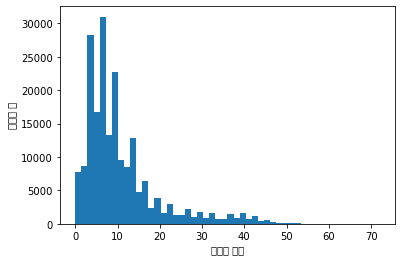

In [37]:
print('리뷰의 최대 길이:', max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이:', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('샘플의 길이')
plt.ylabel('샘플의 수')
plt.show()

In [38]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [39]:
#완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [40]:
print(model.wv.most_similar('최민식'))

[('한석규', 0.8608188033103943), ('안성기', 0.8510144948959351), ('채민서', 0.8500288128852844), ('유다인', 0.8434730768203735), ('양동근', 0.8427008986473083), ('설경구', 0.8323835134506226), ('이민호', 0.8265925645828247), ('올드보이', 0.8265739679336548), ('조재현', 0.8253873586654663), ('윤제문', 0.823427677154541)]


In [43]:
print(model.wv.most_similar('서울'))

[('전주', 0.8096861839294434), ('시네마', 0.8074458241462708), ('부산', 0.7956234216690063), ('침대', 0.7840989232063293), ('메가박스', 0.7763779163360596), ('공항', 0.7676821947097778), ('지하철', 0.7617844939231873), ('영화제', 0.7591466903686523), ('예매', 0.753576397895813), ('대구', 0.7496579885482788)]
